In this file, we will be running multiple linear regression on our dataset.

In [60]:
import pandas as pd
import numpy as np

# Playing around with the working directory so I can get the data in, will change later
import os
os.chdir("C:/Users/mattc/Downloads/home-data-for-ml-course")

housing_data = pd.read_csv('train.csv')
print(housing_data.head)

<bound method NDFrame.head of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Util

Next I'm going to make some adjustments to the data so I can work with it. Namely I will be changing a lot of the categorical variables into multiple dummy variables. 

In [61]:
# Drop Id column as it's completely arbitrary
housing_data = housing_data.drop('Id', axis = 1)

# Remove some columns as all values for them are identical or near identical
housing_data = housing_data.drop("Street", axis = 1)
housing_data = housing_data.drop("RoofMatl", axis = 1)
housing_data = housing_data.drop("PoolQC", axis = 1)
housing_data = housing_data.drop("Utilities", axis = 1)
housing_data = housing_data.drop("Condition1", axis = 1)
housing_data = housing_data.drop("Condition2", axis = 1)

# Change NaN instances in Lotfrontage column to 0
housing_data["LotFrontage"] = housing_data["LotFrontage"].fillna(0)
housing_data["MasVnrArea"] = housing_data["MasVnrArea"].fillna(0)

# Make dataframes for categorical variables, both in their unlatered forms and as dummy variables
categoricals = pd.DataFrame()
for col in housing_data.select_dtypes(include='object'):
    categoricals = pd.concat([categoricals, housing_data[[col]]], axis=1)
    categoricals[col] = categoricals[col].fillna('None')
    housing_data = housing_data.drop(col, axis=1)

# Get the response variable as a separate vector
y = housing_data['SalePrice']
housing_data = housing_data.drop('SalePrice', axis = 1)

# Get a dataframe of just quantitative variables
quantitatives = housing_data


Now that the data is in a workable form, we can start analyzing it. Given there are so many predictor variables, there's a good chance some of them exhibit some multicollinearity. So before anything else, I will analyze for multicollinearity among the predictors and remove any that exhibit it. I will do this using the pairwise correlation matrix of all the quantitative variables.  

In [62]:
# Create Pairwise Correlation Matrix
corr_matrix = quantitatives.corr()

# Find all values higher than 0.6 and list them, these will be considered for dropping
high_corr_pairs = []
for row in corr_matrix.index:
    for col in corr_matrix.columns:
        if row != col and np.abs(corr_matrix.loc[row, col]) > 0.6:
            high_corr_pairs.append((row, col, corr_matrix.loc[row, col]))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Variable 1", "Variable 2", "Correlation"])
print(high_corr_df)

      Variable 1    Variable 2  Correlation
0    OverallQual    GarageCars     0.600671
1      YearBuilt   GarageYrBlt     0.825667
2   YearRemodAdd   GarageYrBlt     0.642277
3     BsmtFinSF1  BsmtFullBath     0.649212
4    TotalBsmtSF      1stFlrSF     0.819530
5       1stFlrSF   TotalBsmtSF     0.819530
6       2ndFlrSF     GrLivArea     0.687501
7       2ndFlrSF      HalfBath     0.609707
8       2ndFlrSF  TotRmsAbvGrd     0.616423
9      GrLivArea      2ndFlrSF     0.687501
10     GrLivArea      FullBath     0.630012
11     GrLivArea  TotRmsAbvGrd     0.825489
12  BsmtFullBath    BsmtFinSF1     0.649212
13      FullBath     GrLivArea     0.630012
14      HalfBath      2ndFlrSF     0.609707
15  BedroomAbvGr  TotRmsAbvGrd     0.676620
16  TotRmsAbvGrd      2ndFlrSF     0.616423
17  TotRmsAbvGrd     GrLivArea     0.825489
18  TotRmsAbvGrd  BedroomAbvGr     0.676620
19   GarageYrBlt     YearBuilt     0.825667
20   GarageYrBlt  YearRemodAdd     0.642277
21    GarageCars   OverallQual  

Judging by the pairwise correlation matrix, it seems that a lot of the multicollinearity in this data stems around the size of the house and when it was built. As such we'll remove some of the redundancy.

In [63]:
# Dropping Columns
columns_to_drop = ['GarageYrBlt', 'TotRmsAbvGrd', 'GarageCars', '2ndFlrSF']
housing_data = housing_data.drop(columns = columns_to_drop)
quantitatives = quantitatives.drop(columns = columns_to_drop)

Now that much of the multicollinearity is out of the way, we'll examine if any of the remaining qualitative predictors have a relationship with the response, and drop those that don't seem to. We'll do this with scatterplots. 

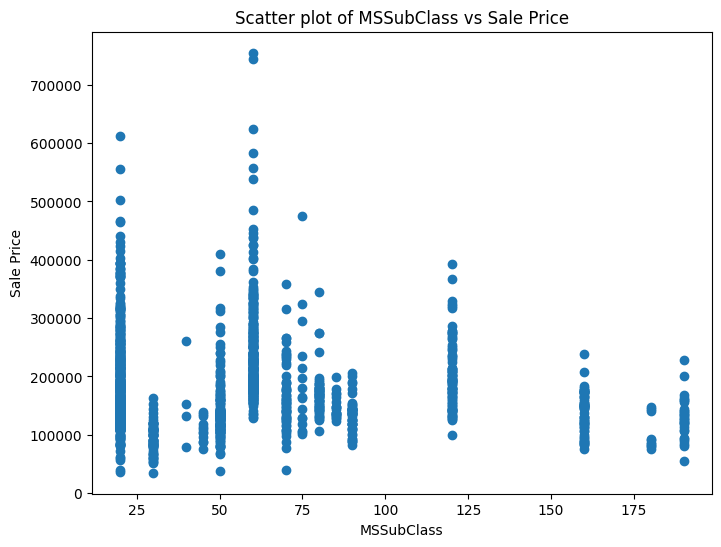

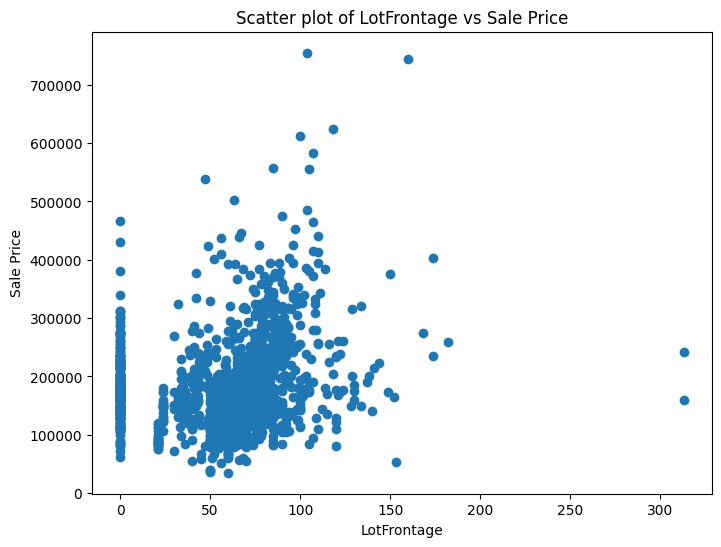

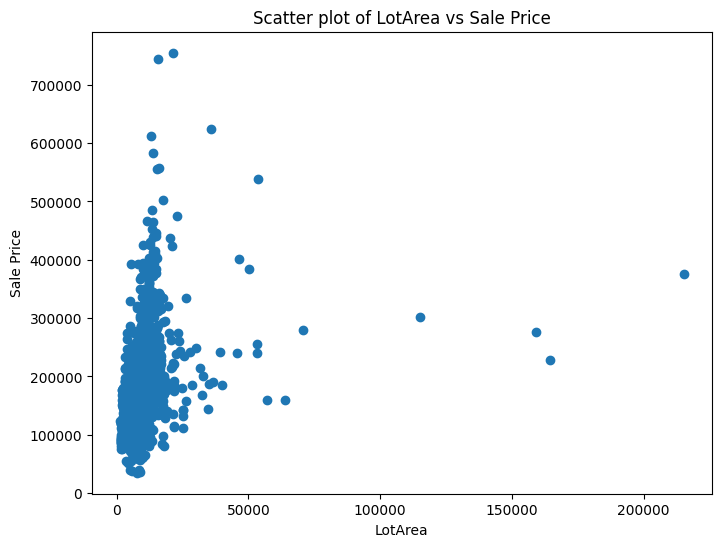

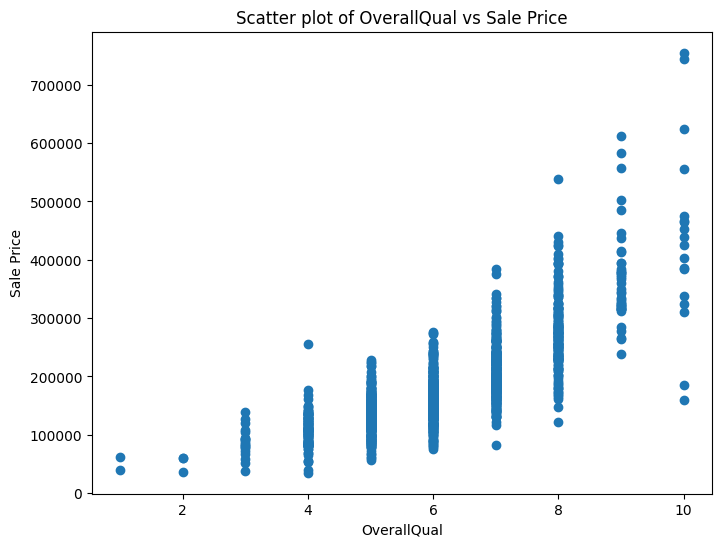

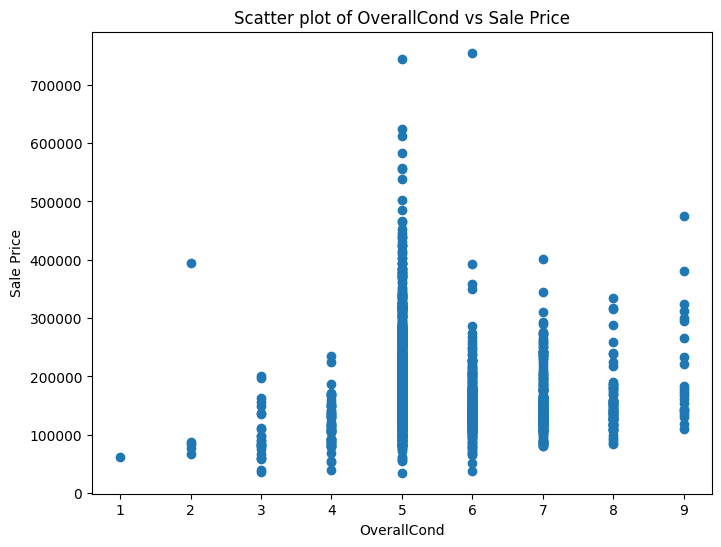

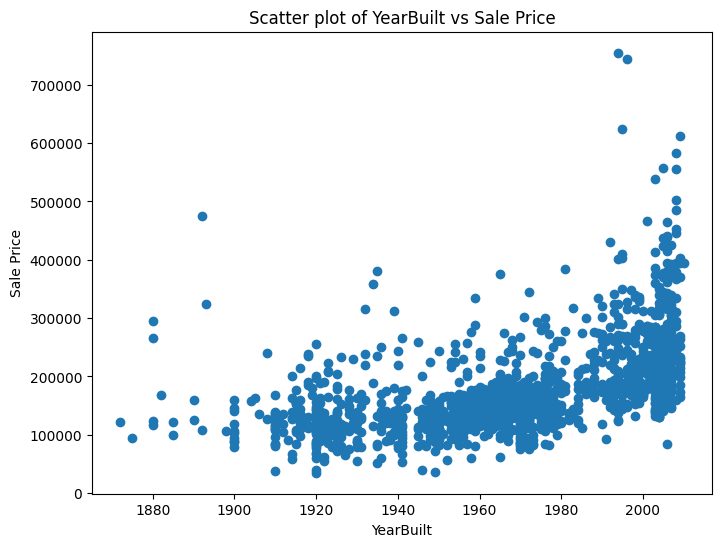

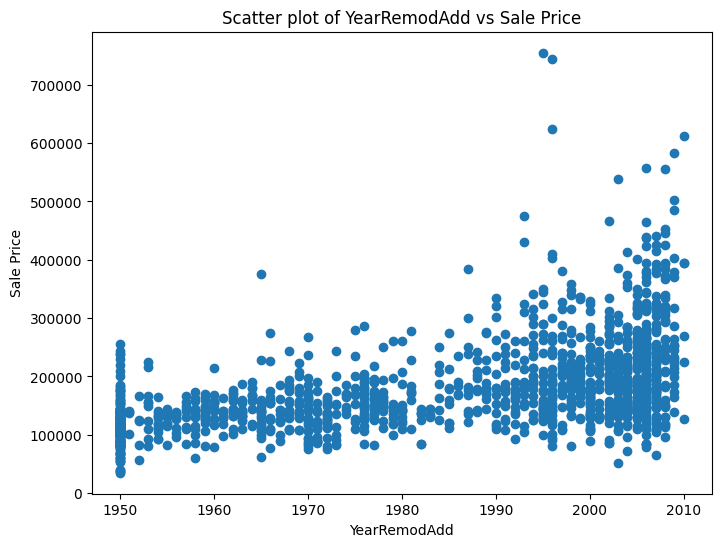

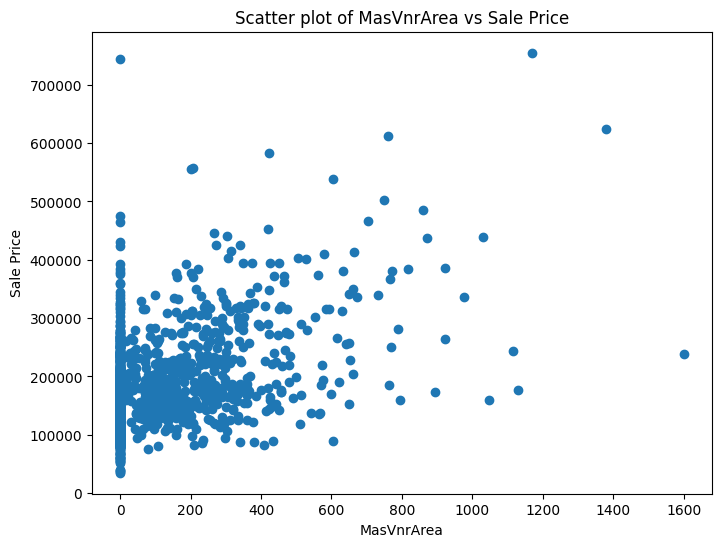

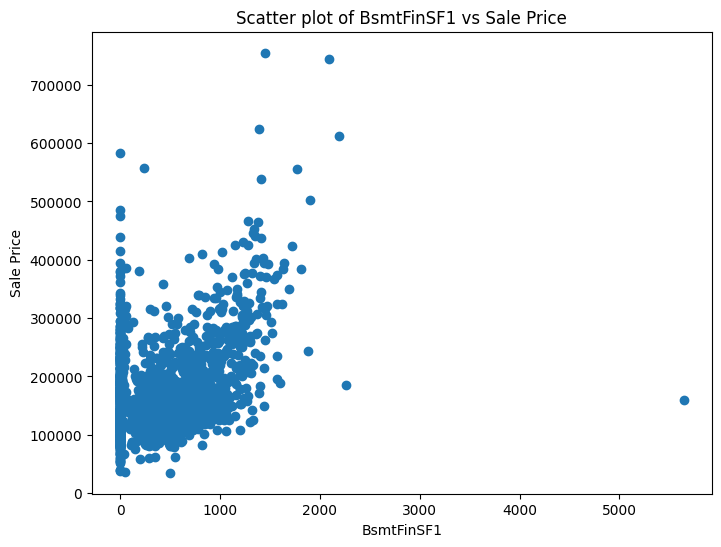

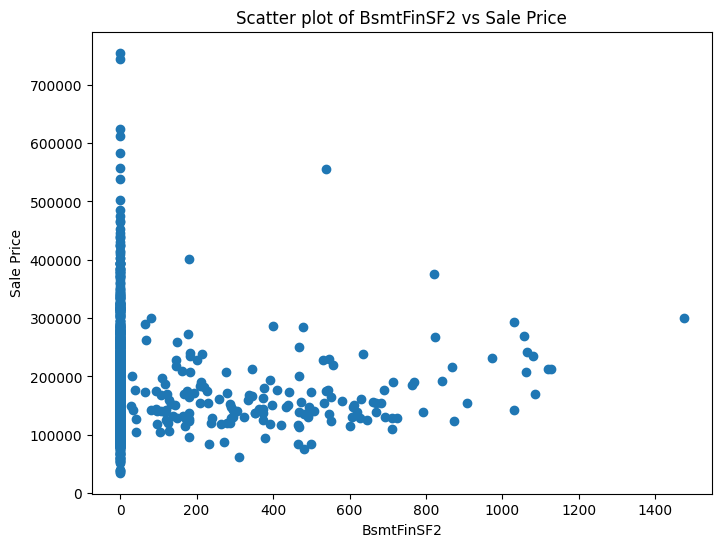

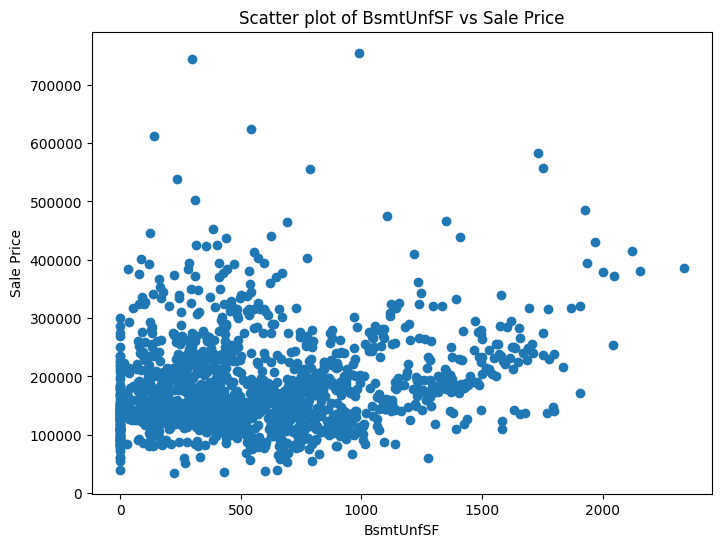

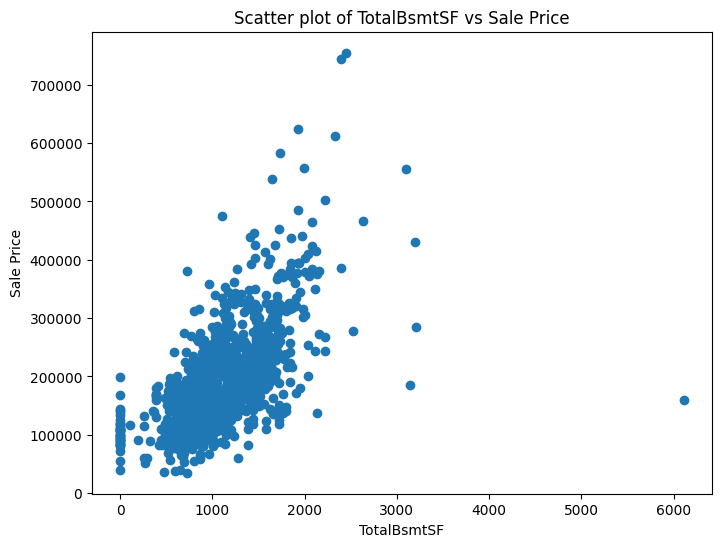

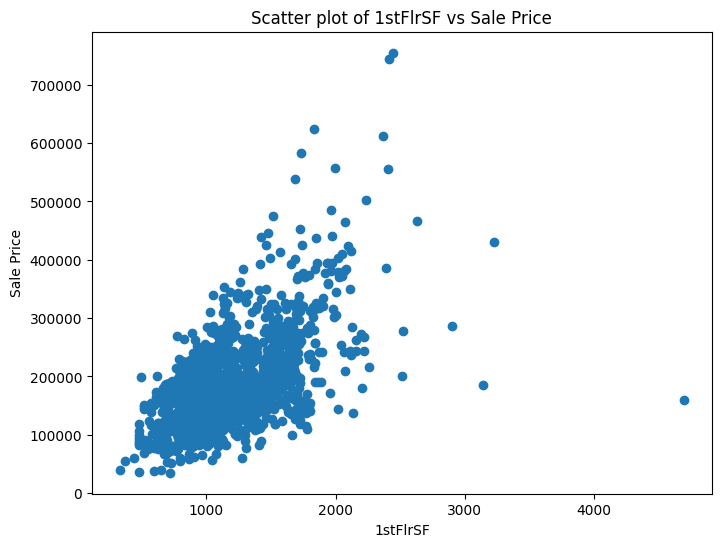

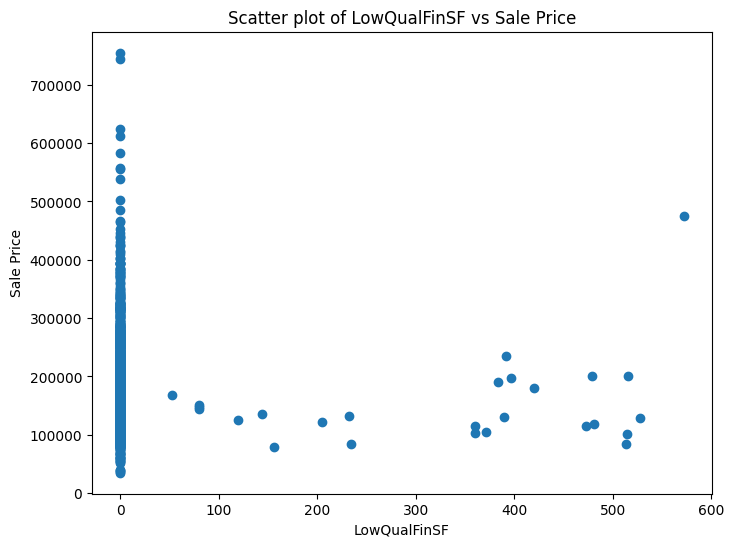

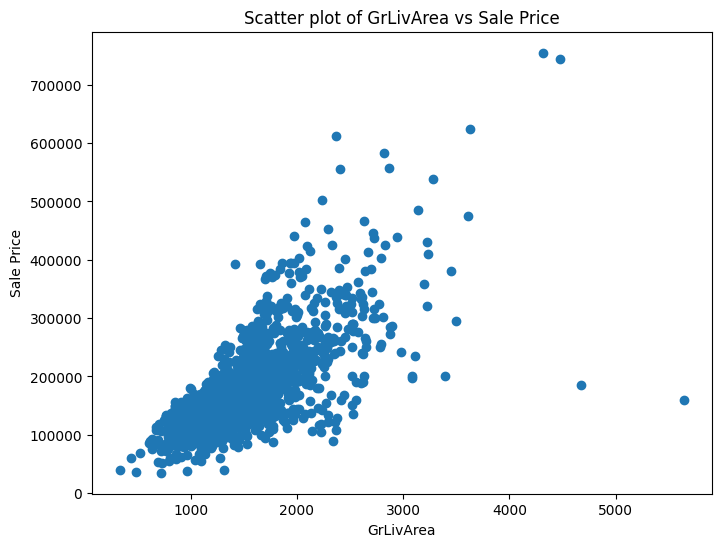

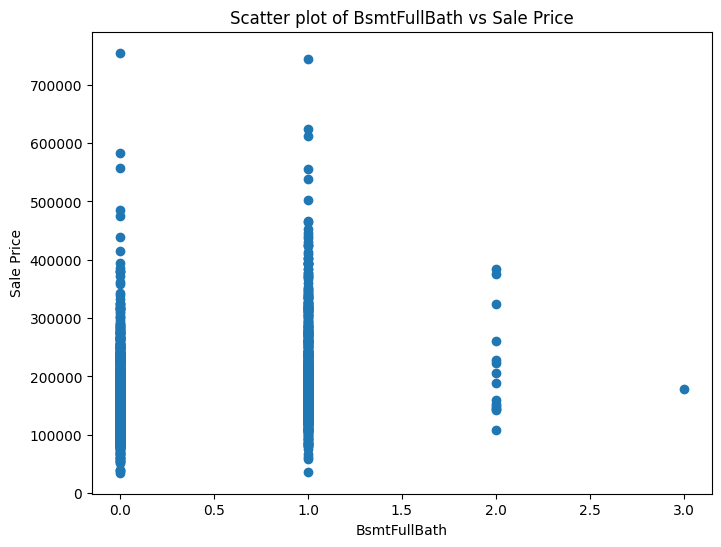

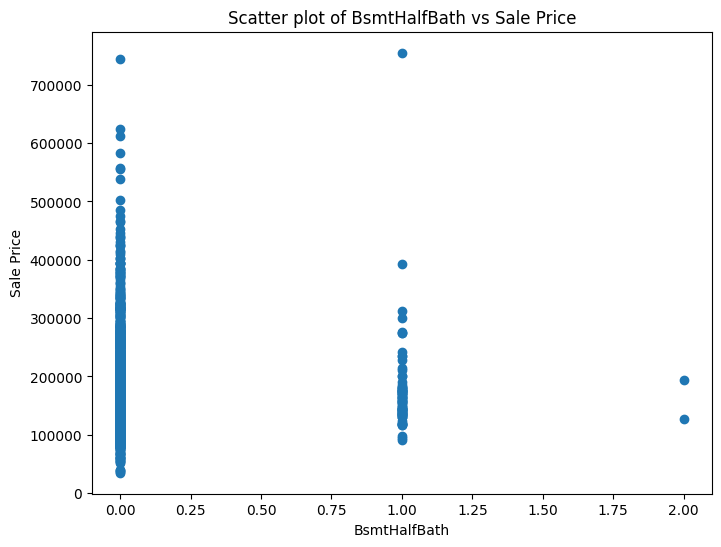

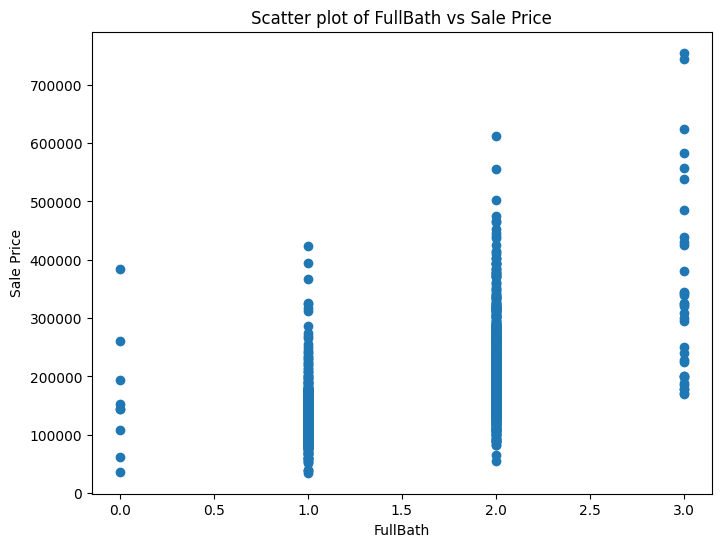

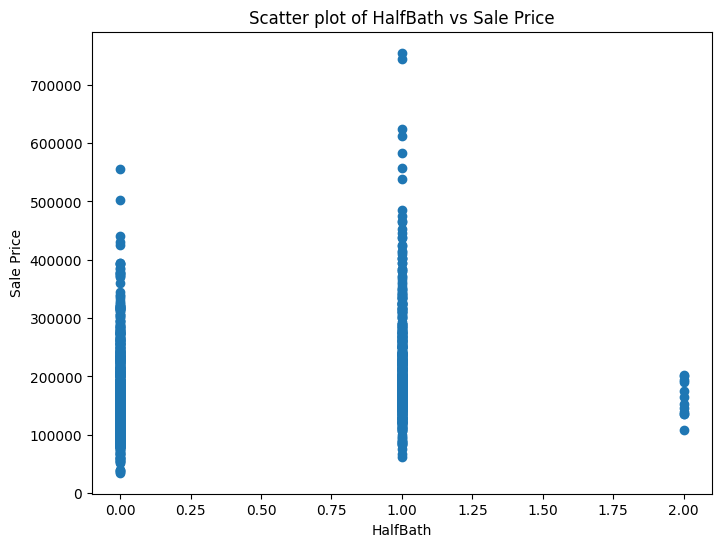

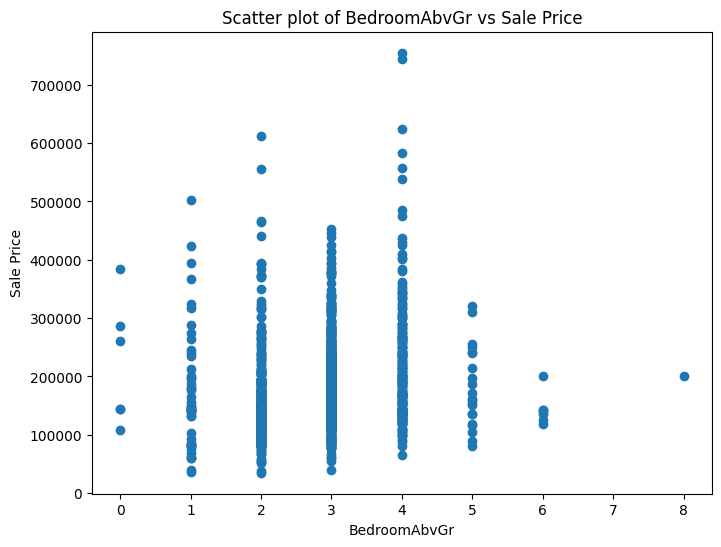

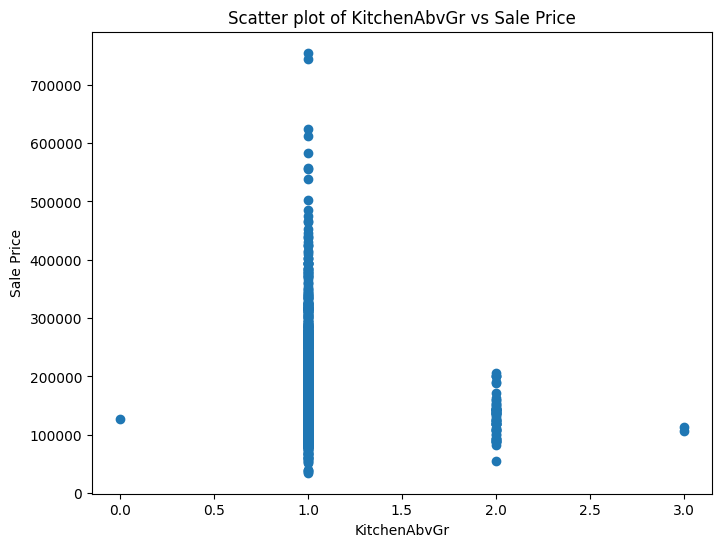

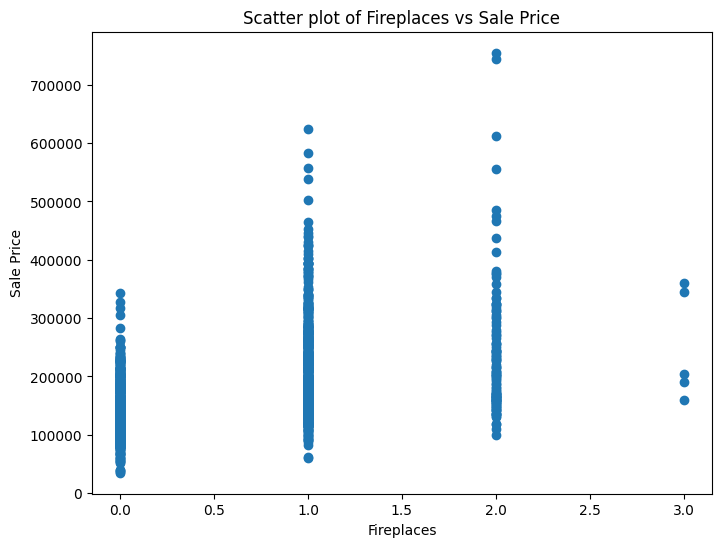

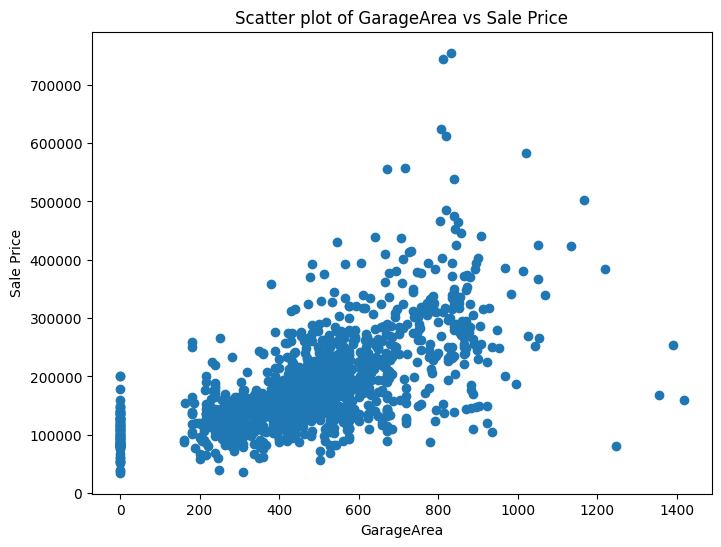

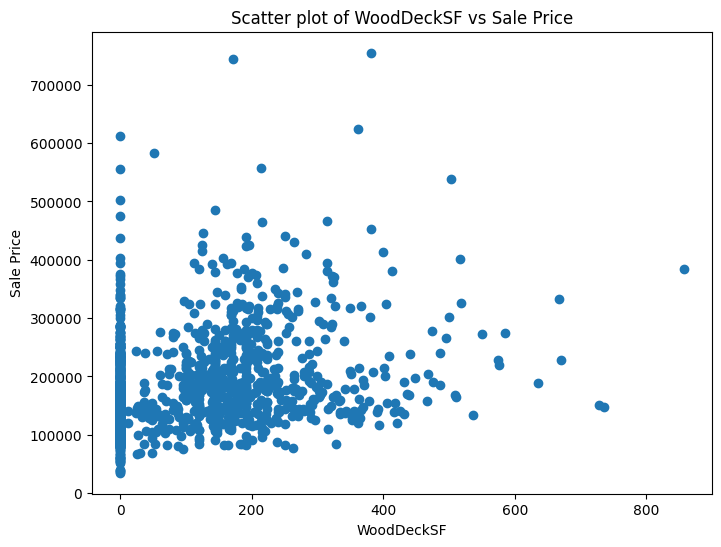

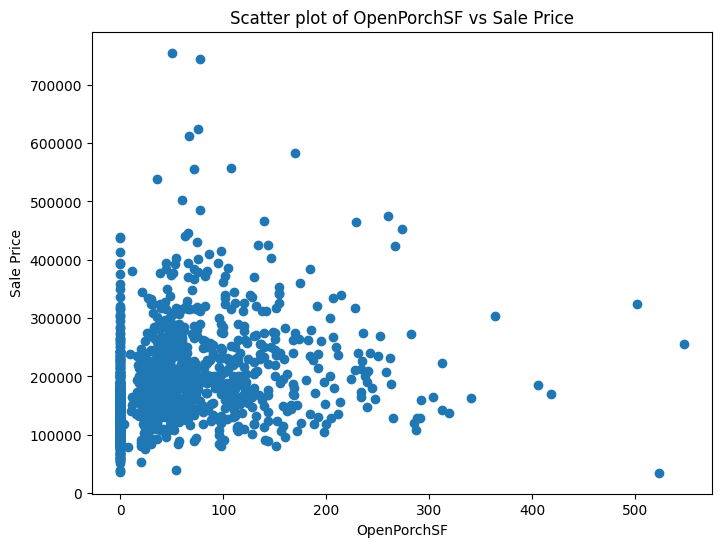

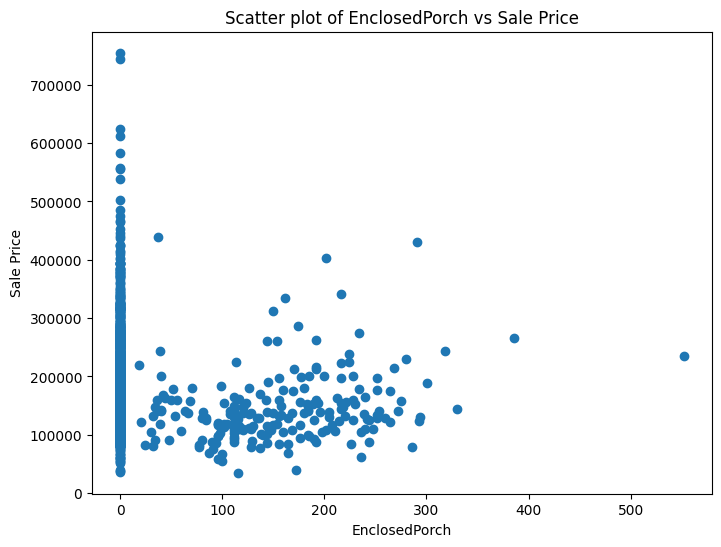

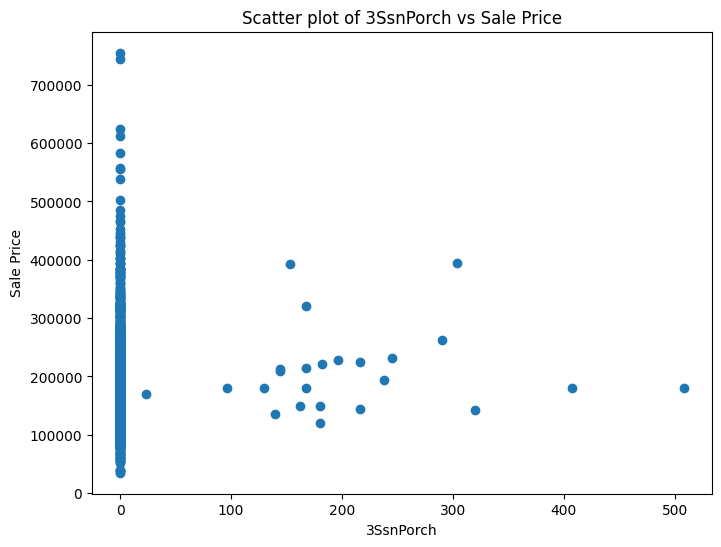

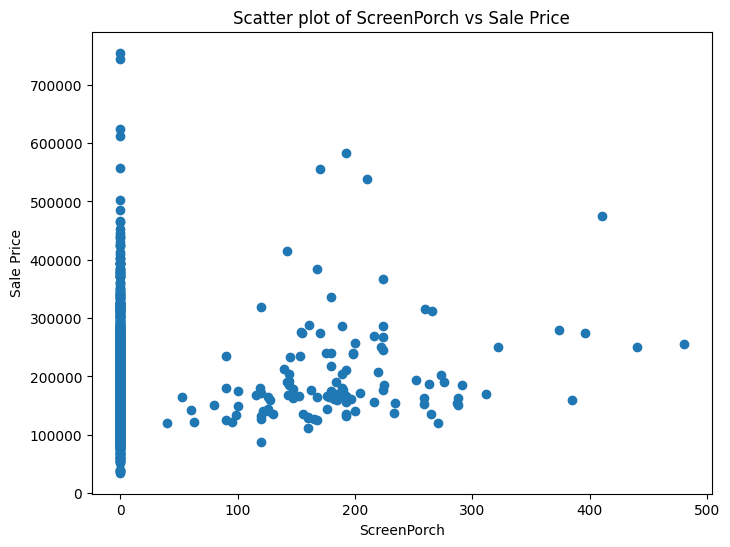

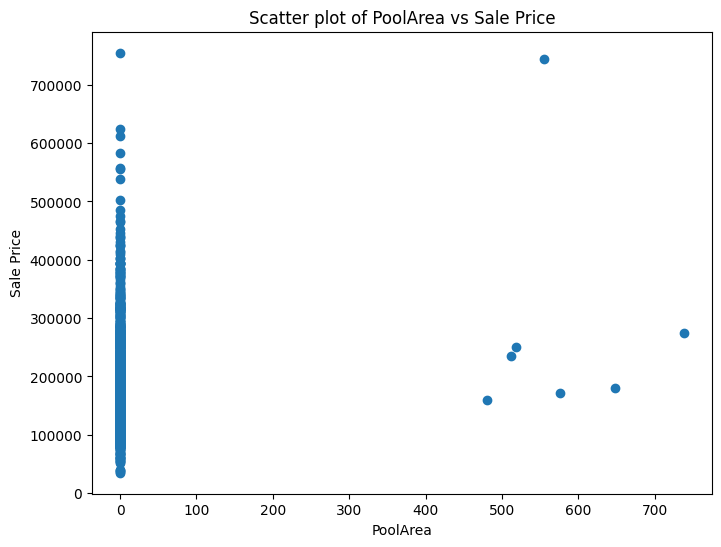

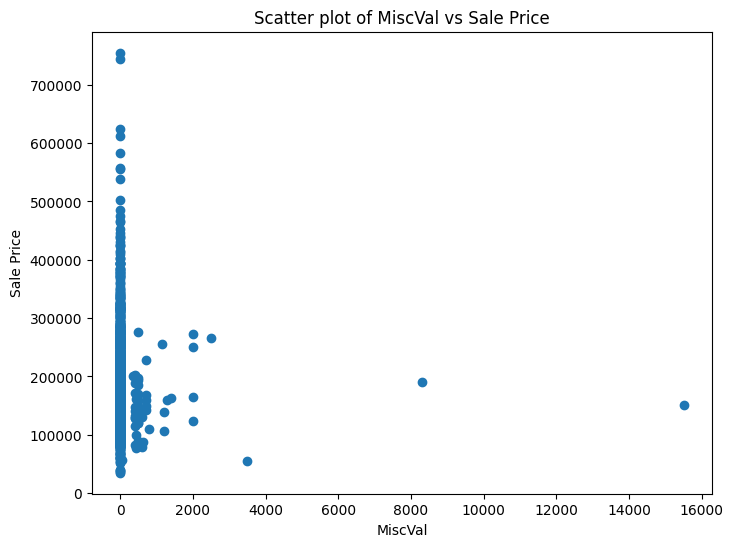

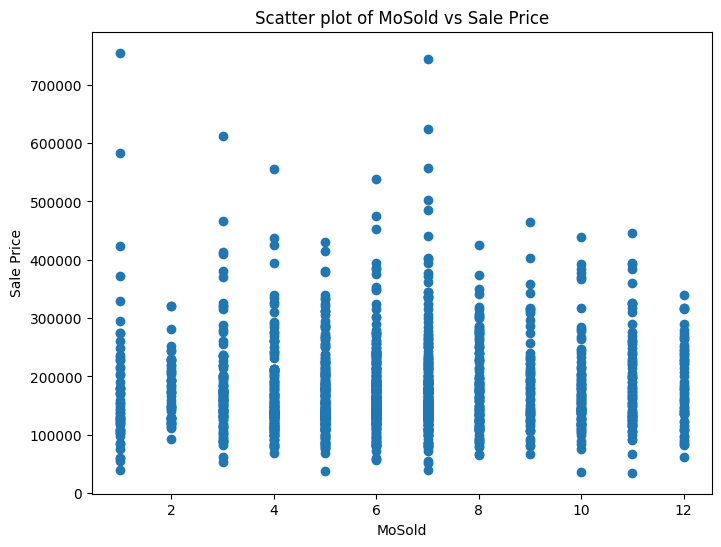

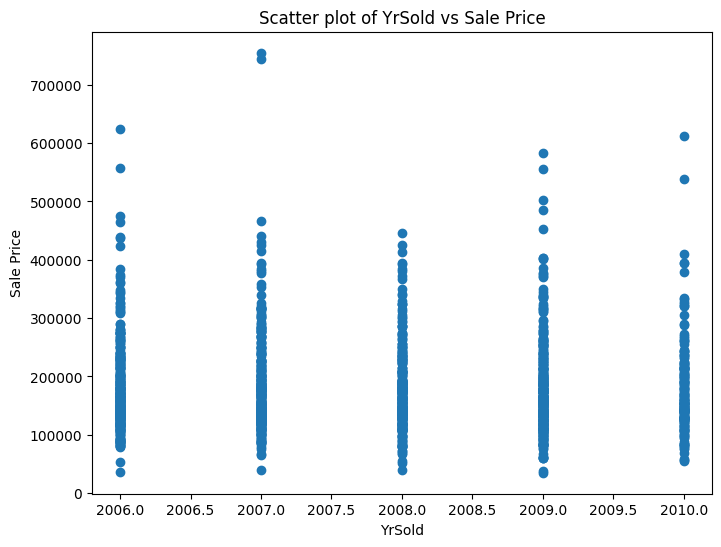

In [64]:
import matplotlib.pyplot as plt

for col in quantitatives.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(quantitatives[col], y)
    plt.title(f'Scatter plot of {col} vs Sale Price')
    plt.xlabel(col)
    plt.ylabel('Sale Price')
    plt.show()

In [65]:
columns_to_drop = ['YrSold', 'MoSold', 'MiscVal', 'PoolArea', 'KitchenAbvGr', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath', 'MSSubClass']
housing_data = housing_data.drop(columns=columns_to_drop)
quantitatives = quantitatives.drop(columns=columns_to_drop)

Next, we'll see which qualitative variables exhibit a relationship with the response by examining their boxplots across different levels. 

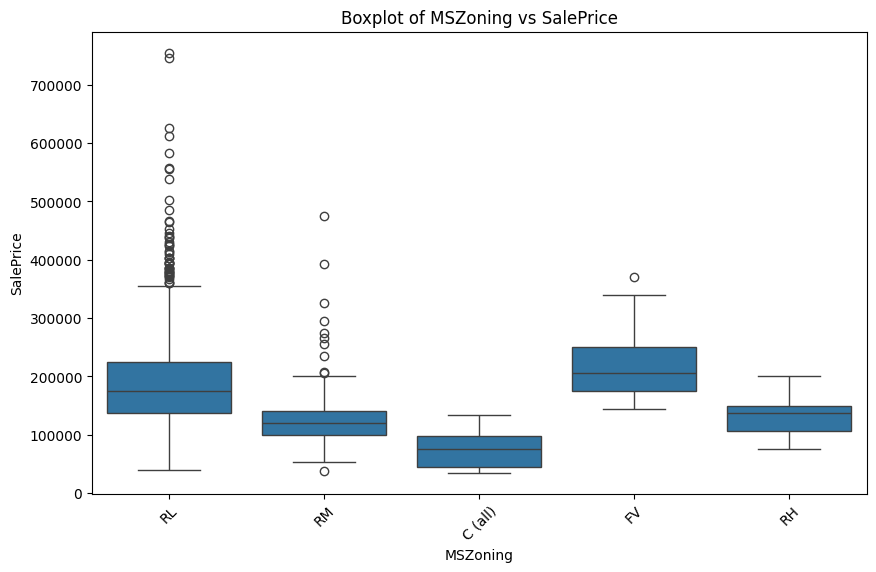

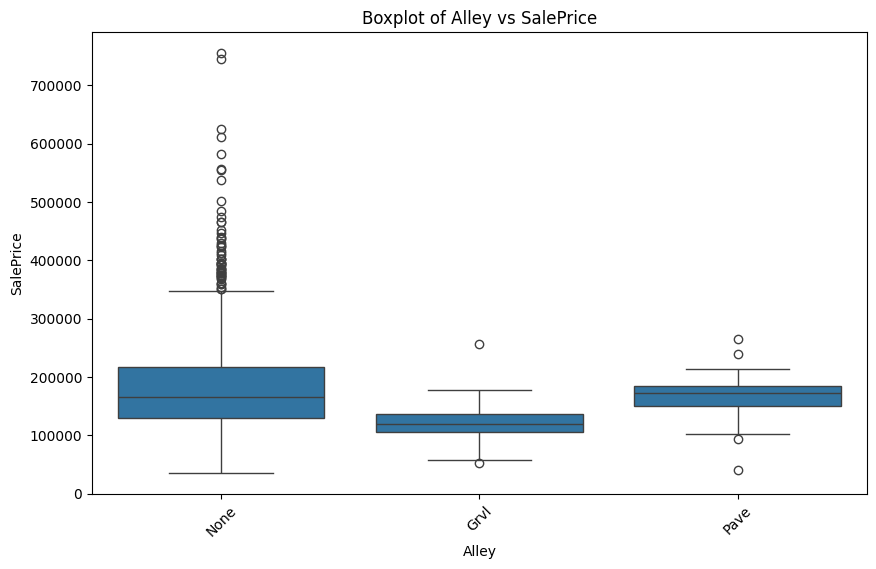

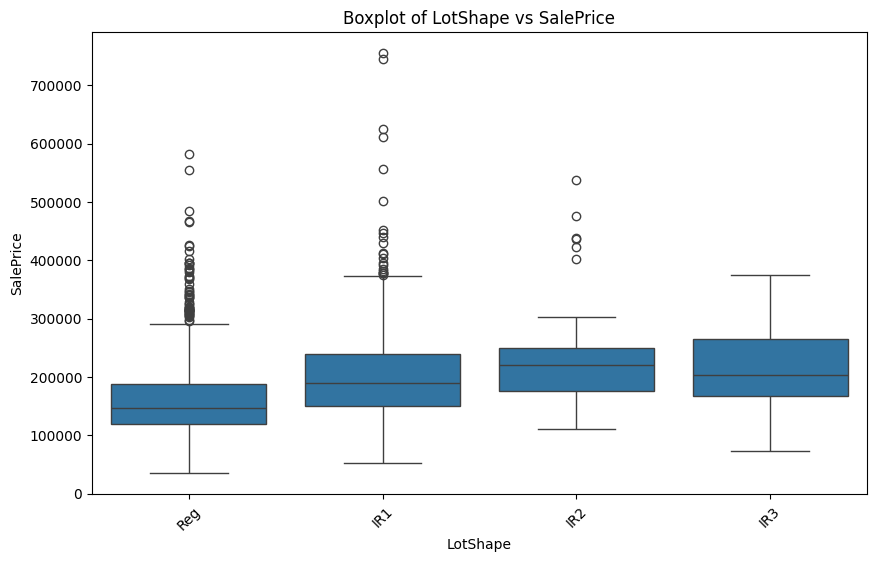

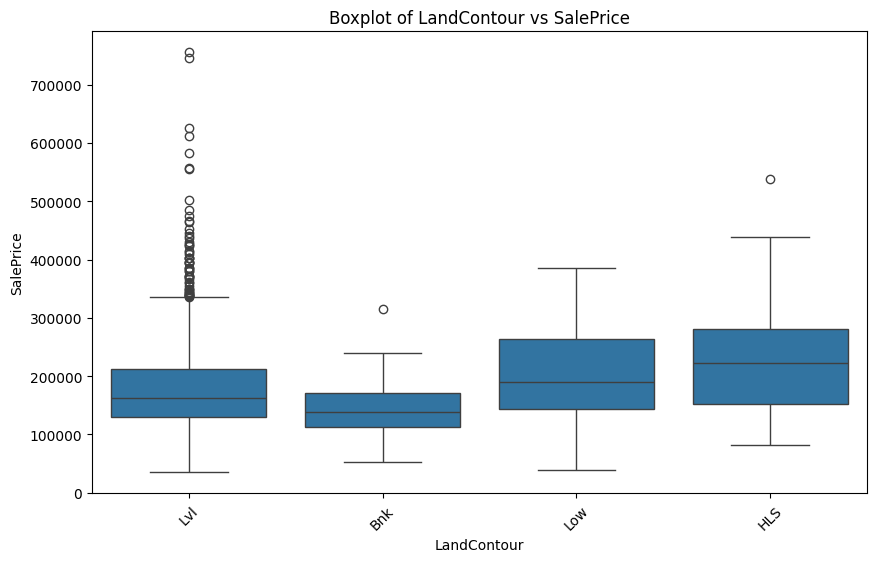

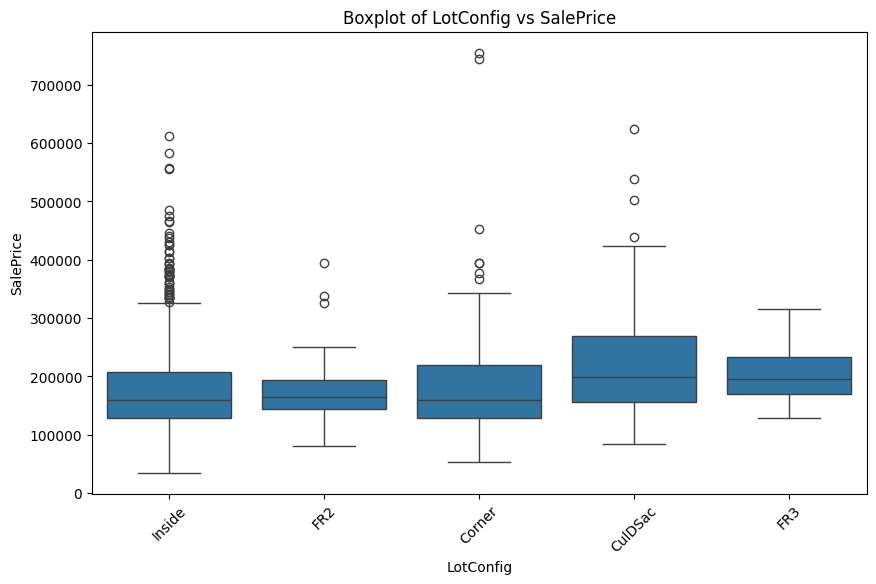

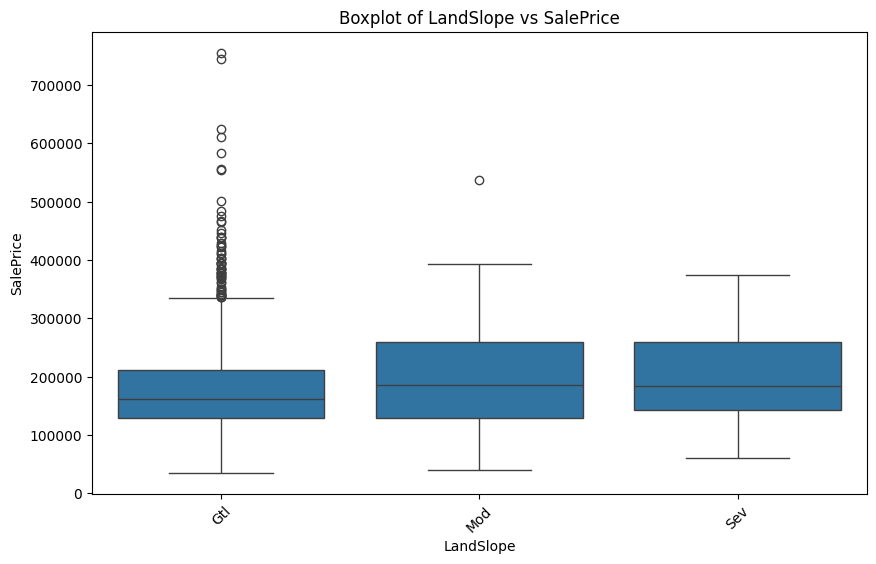

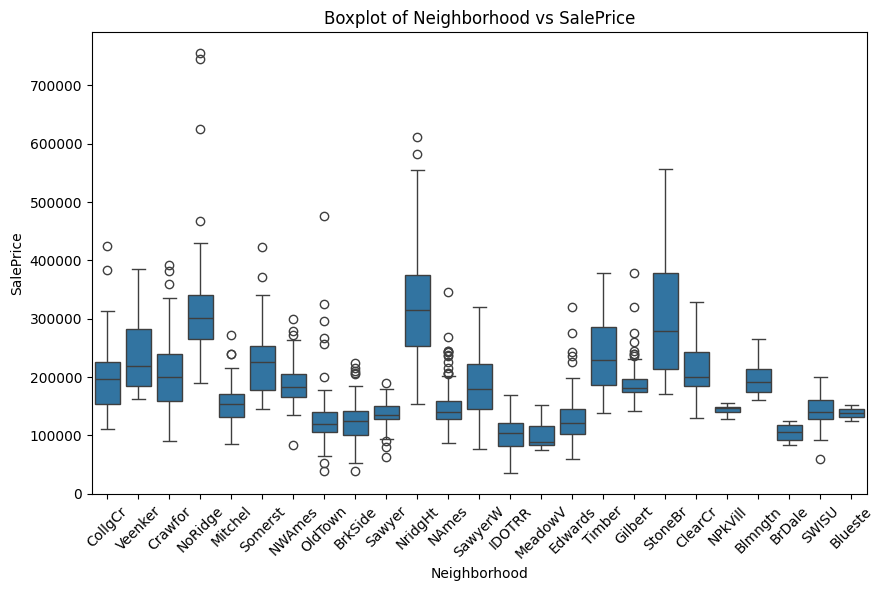

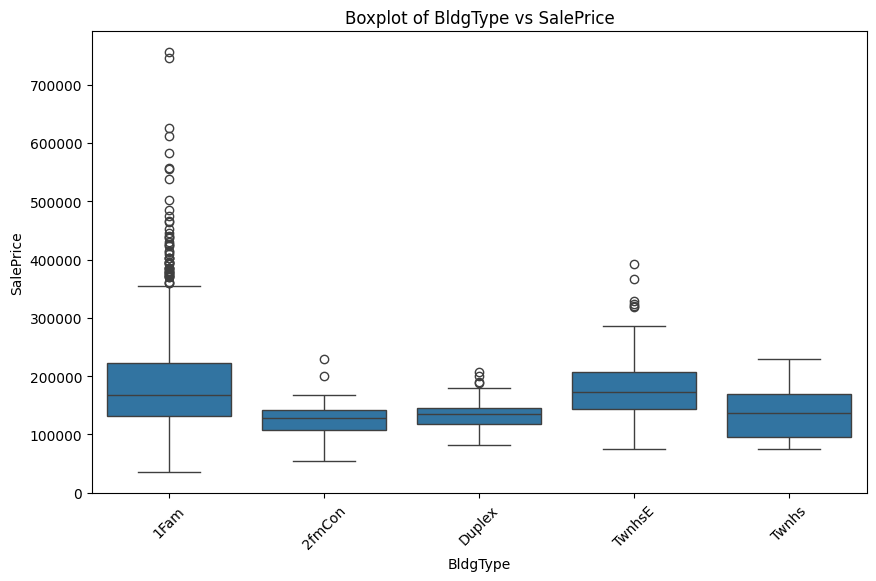

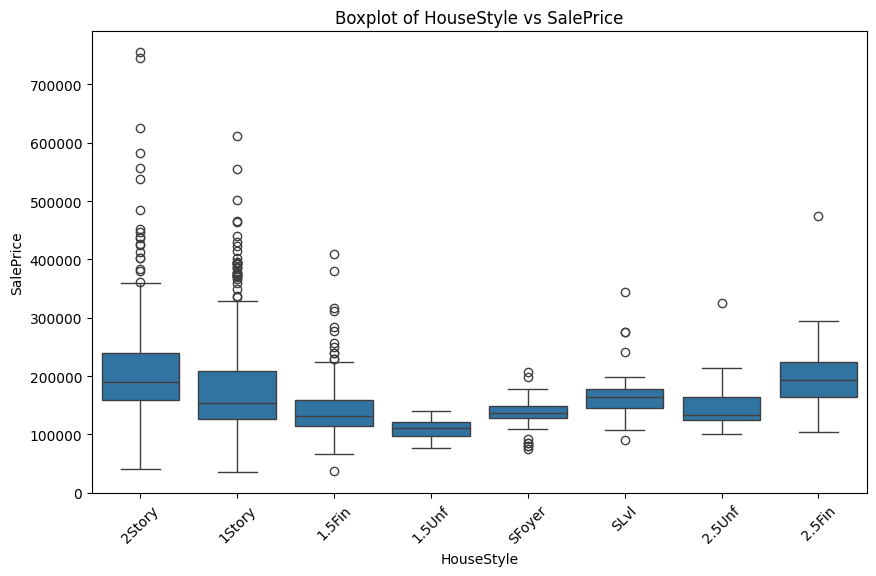

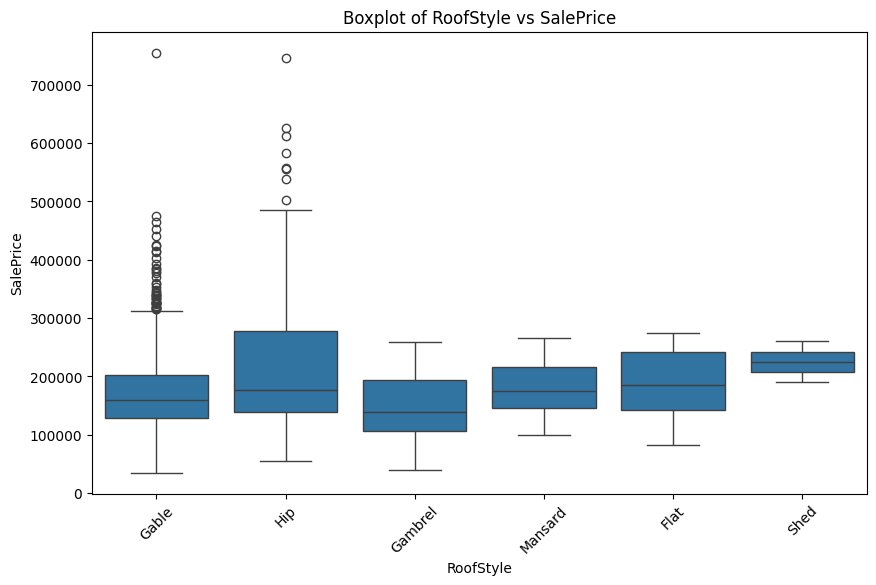

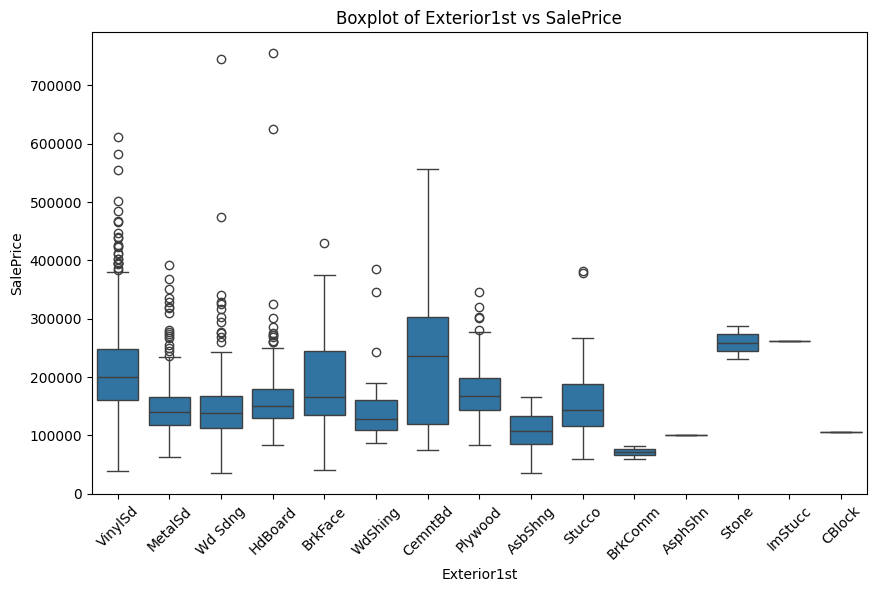

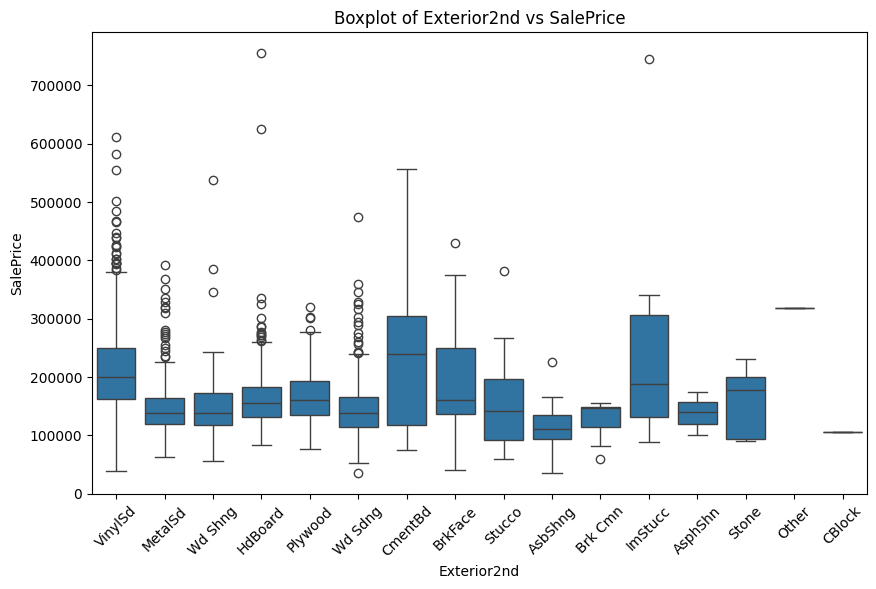

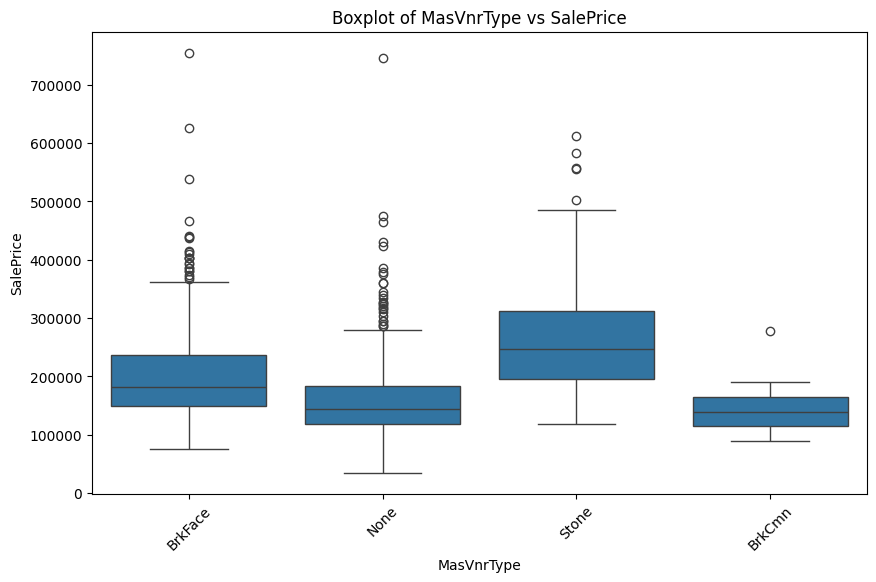

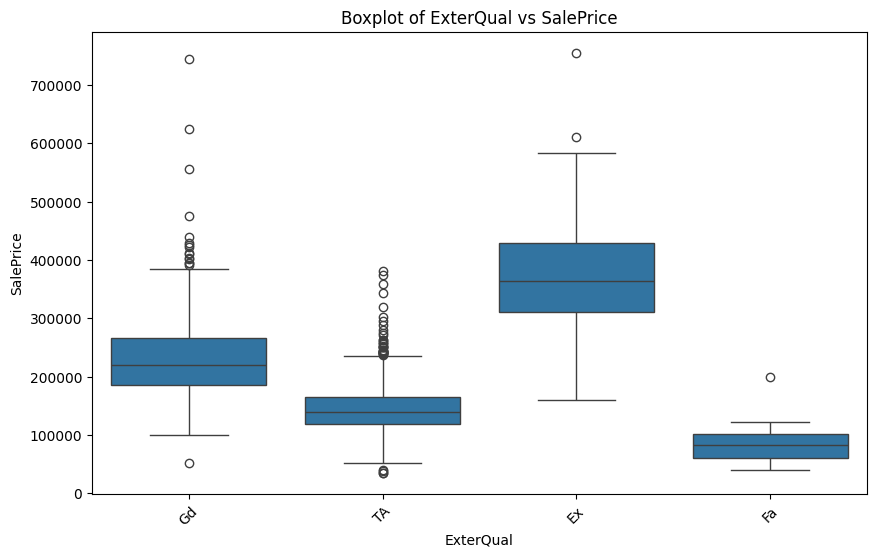

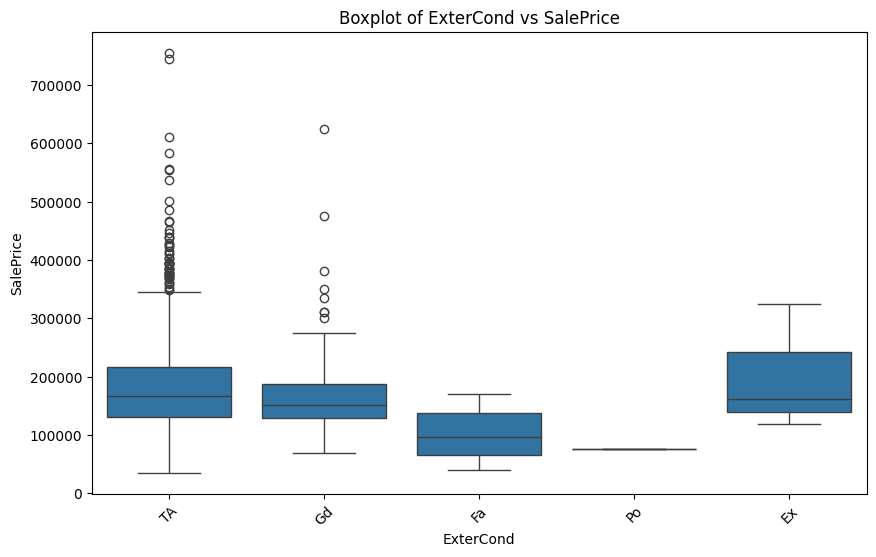

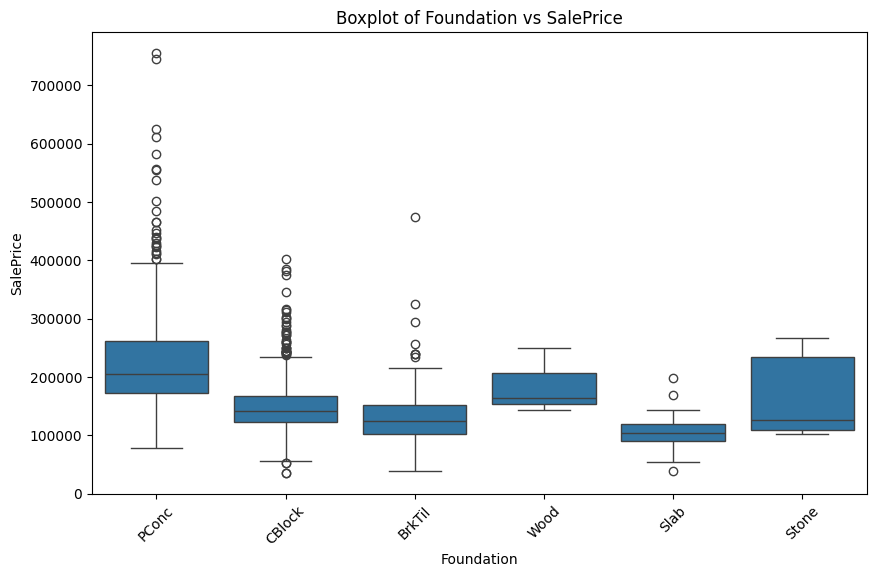

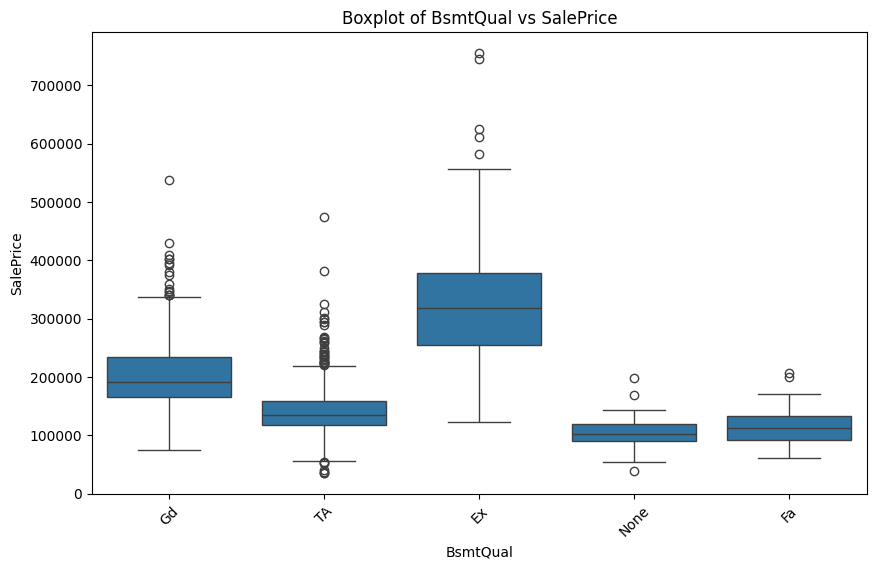

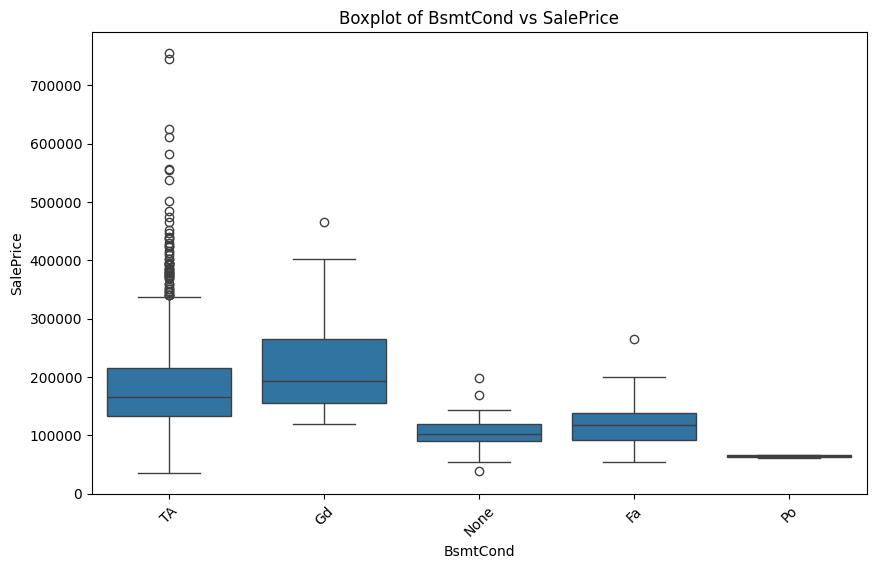

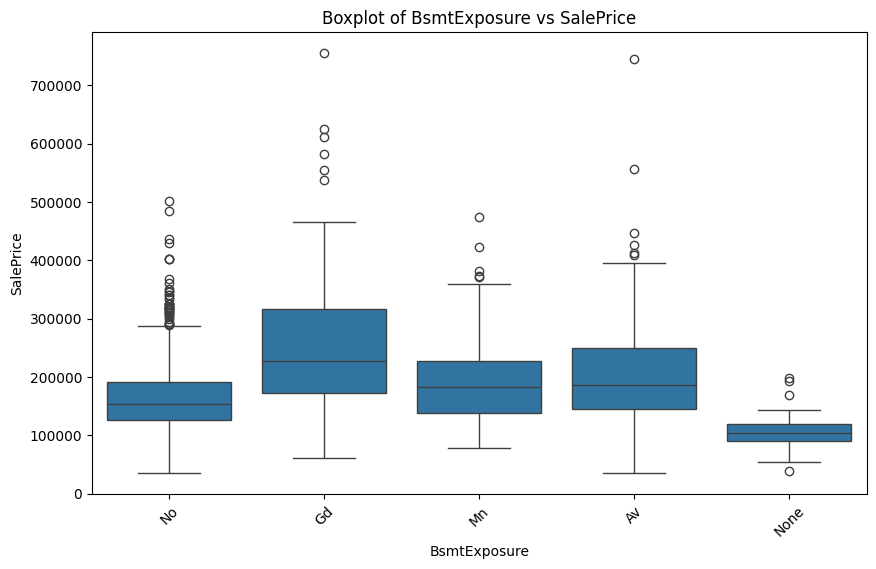

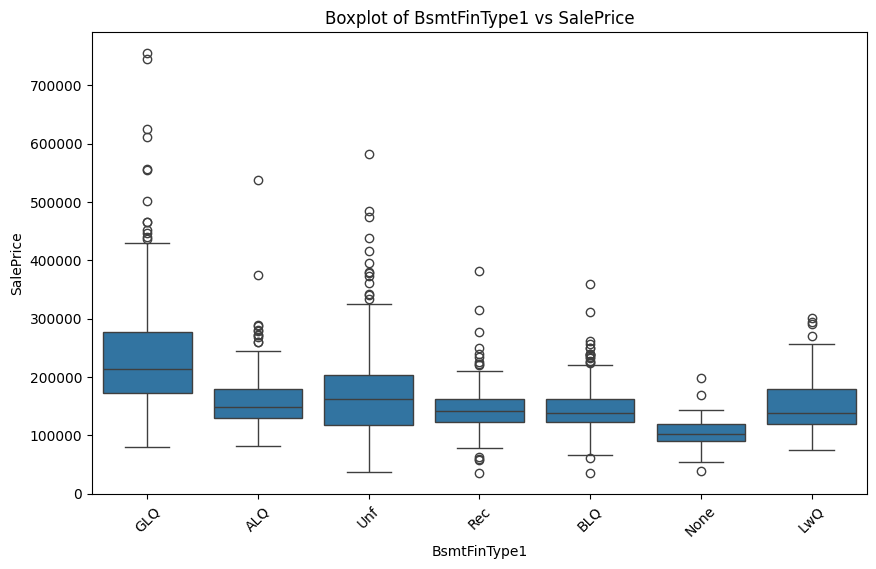

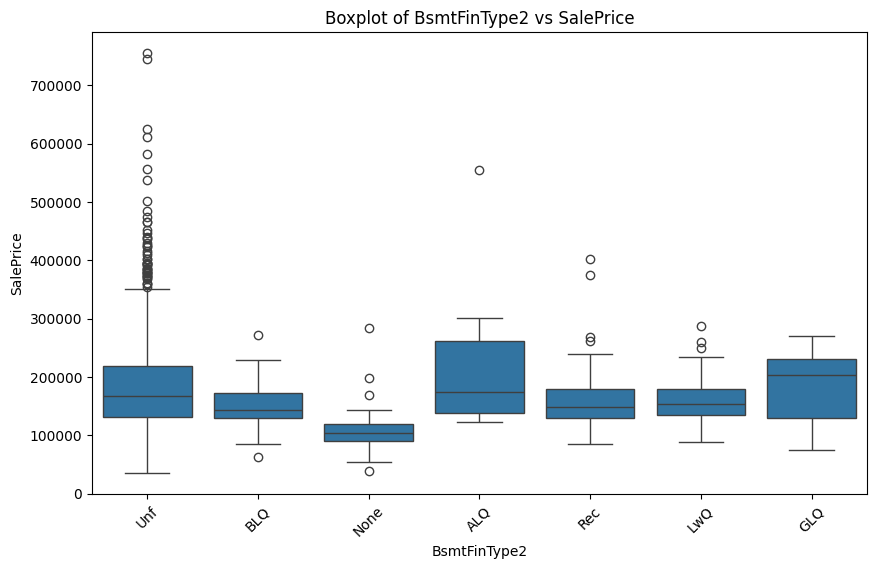

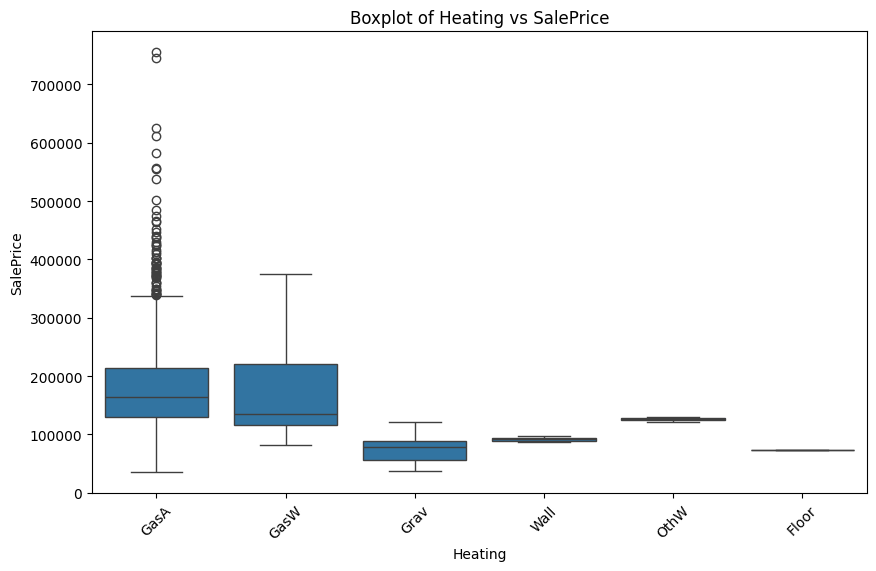

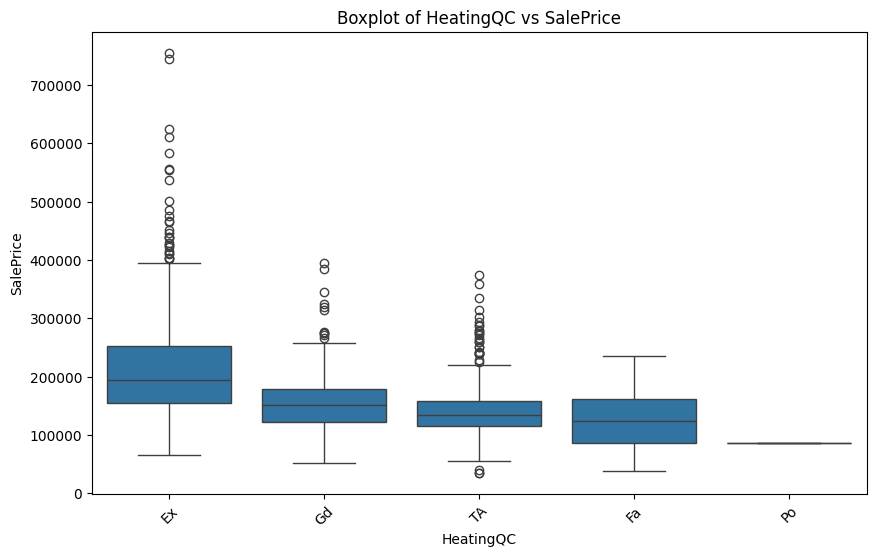

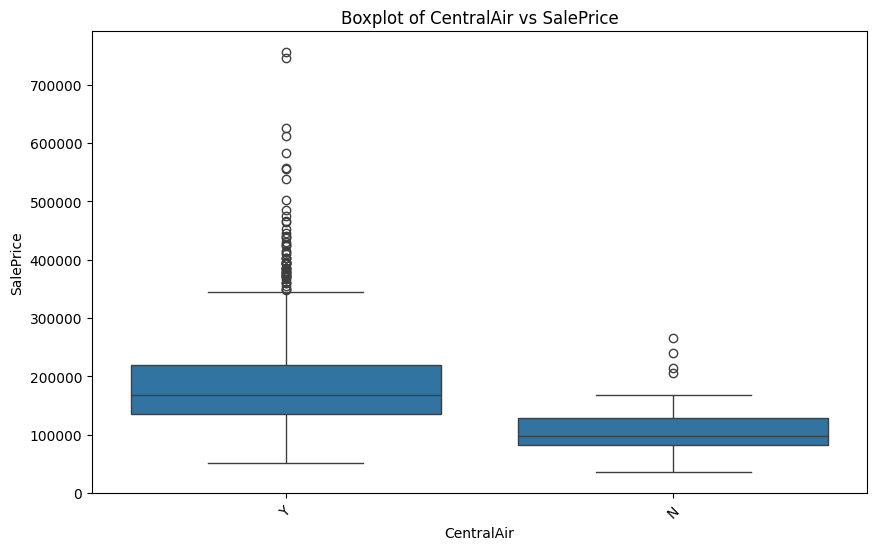

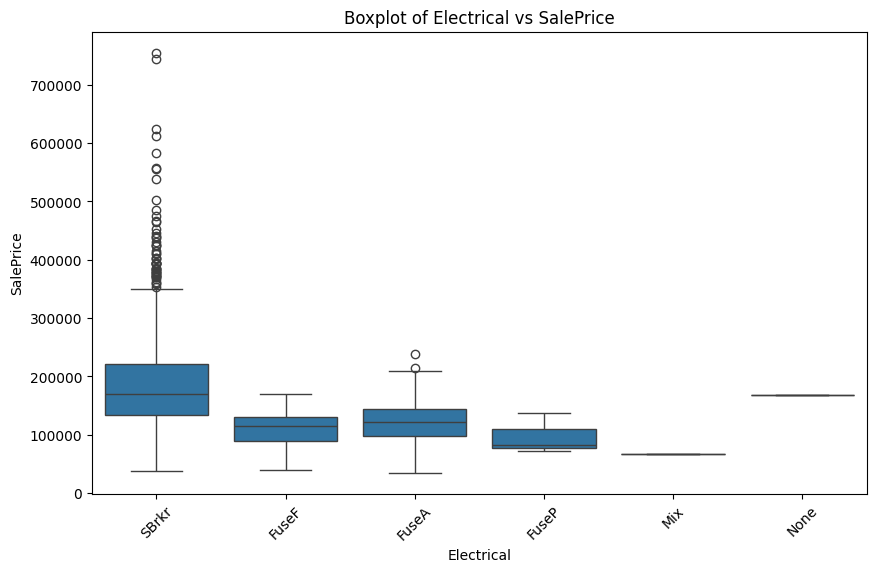

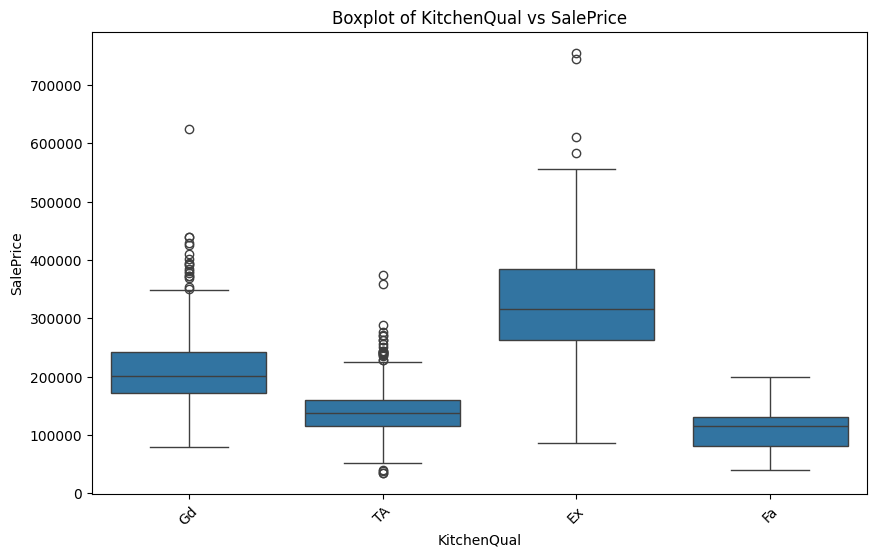

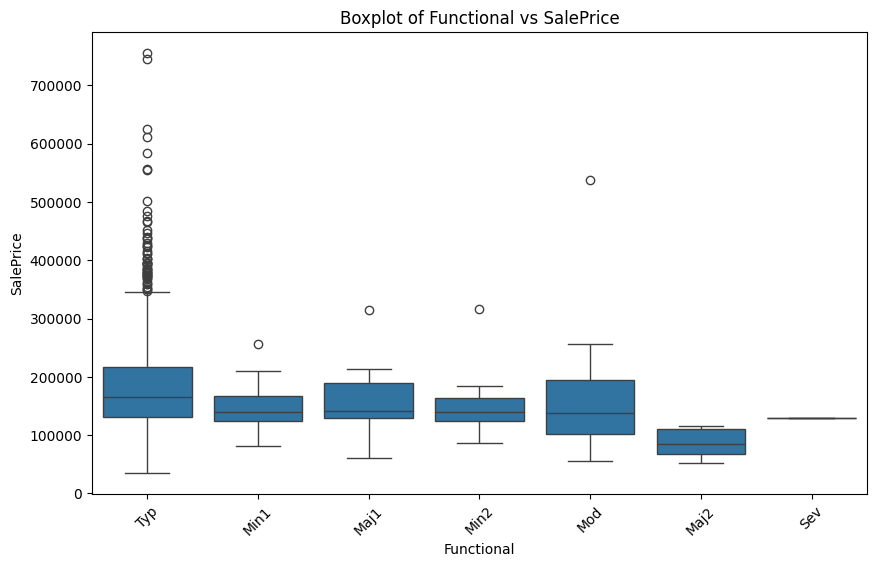

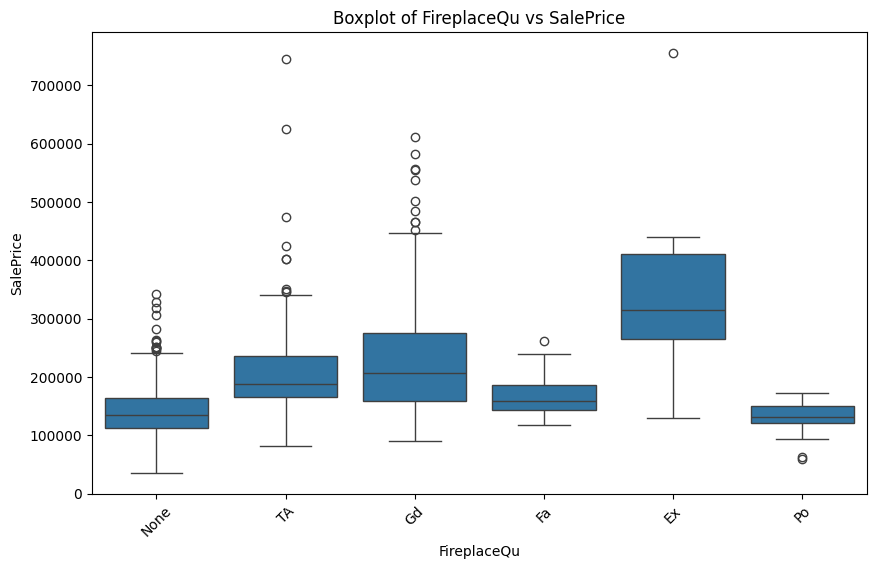

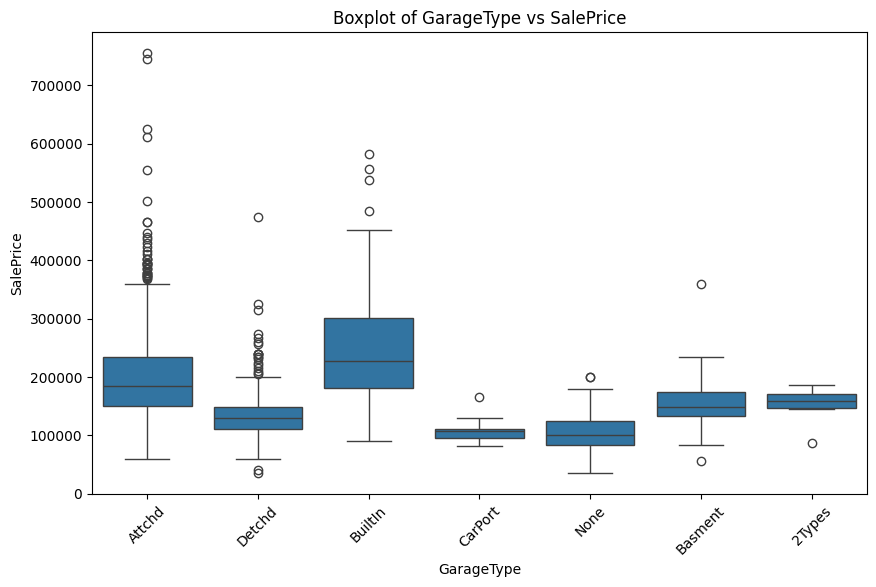

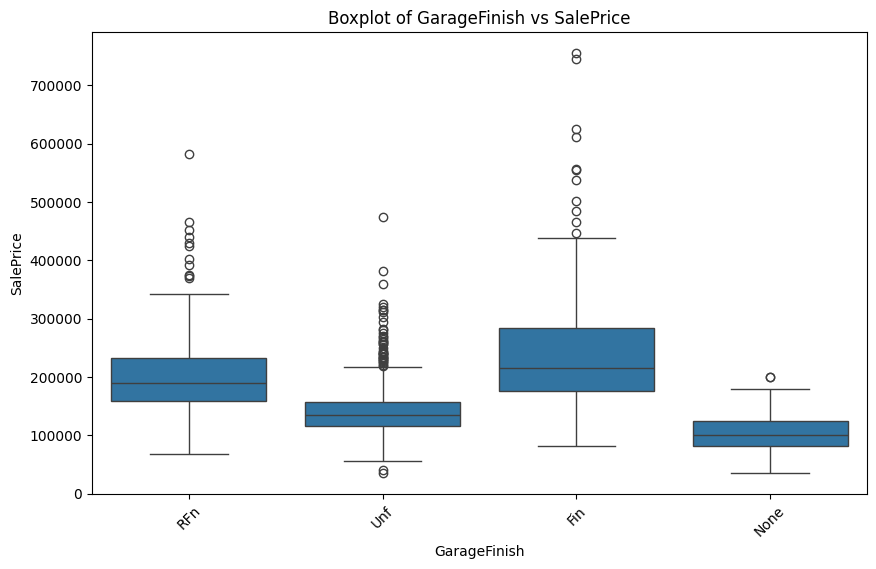

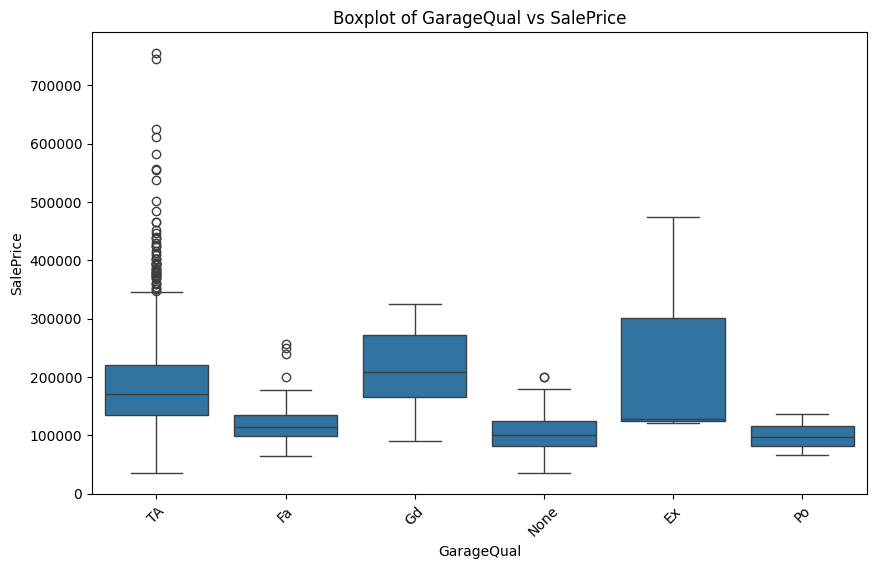

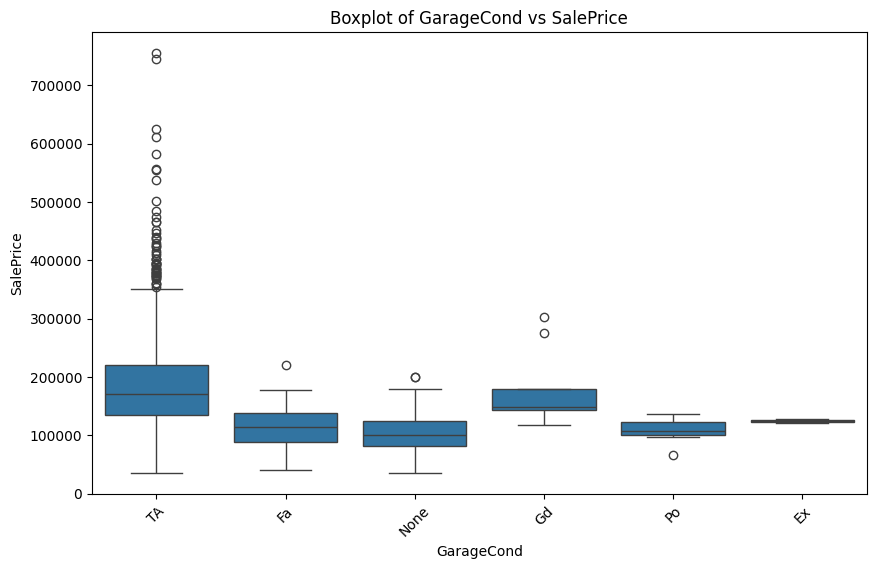

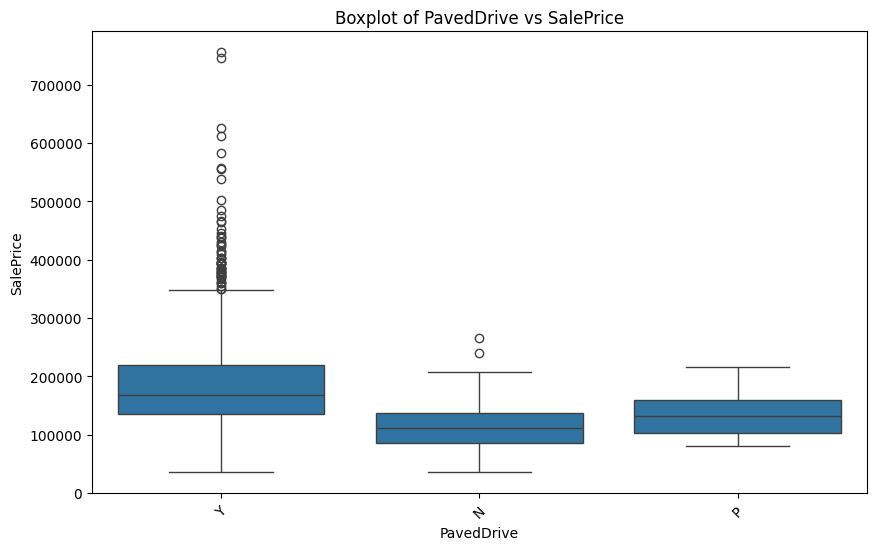

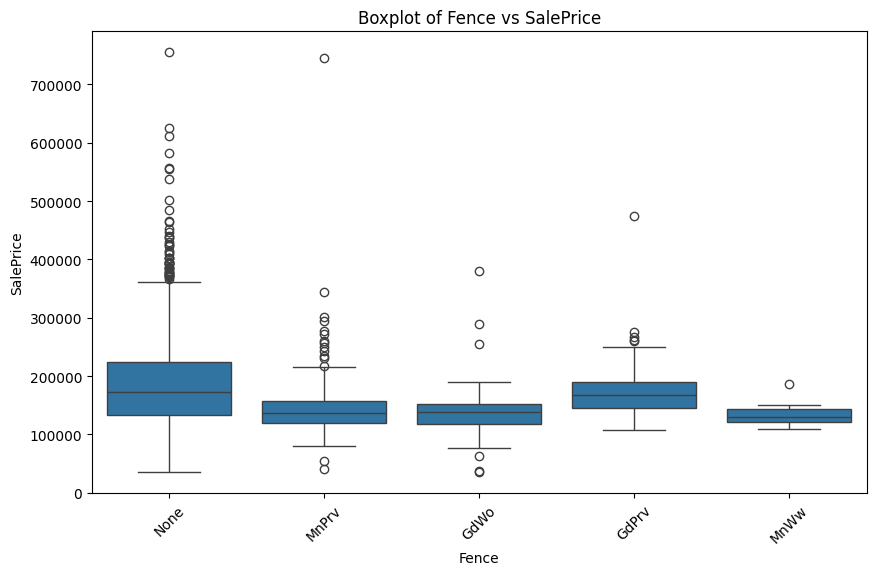

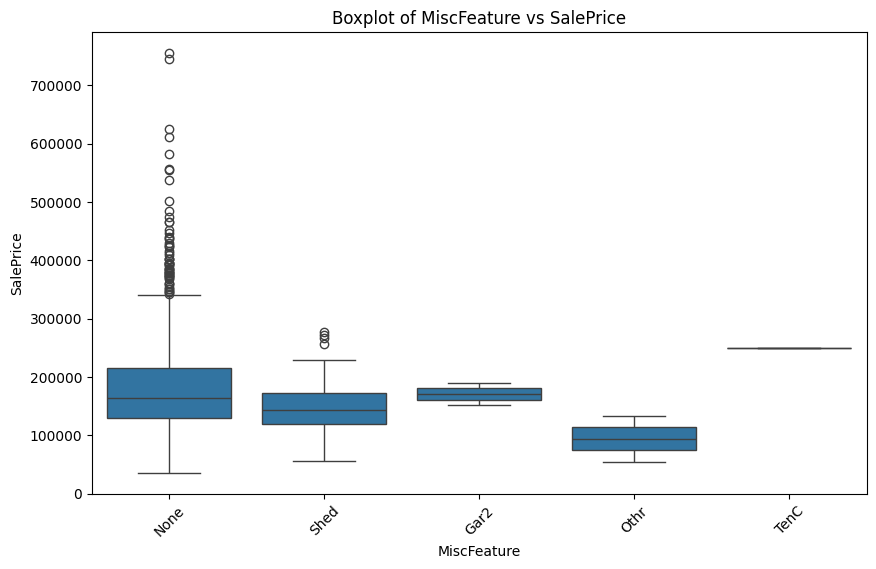

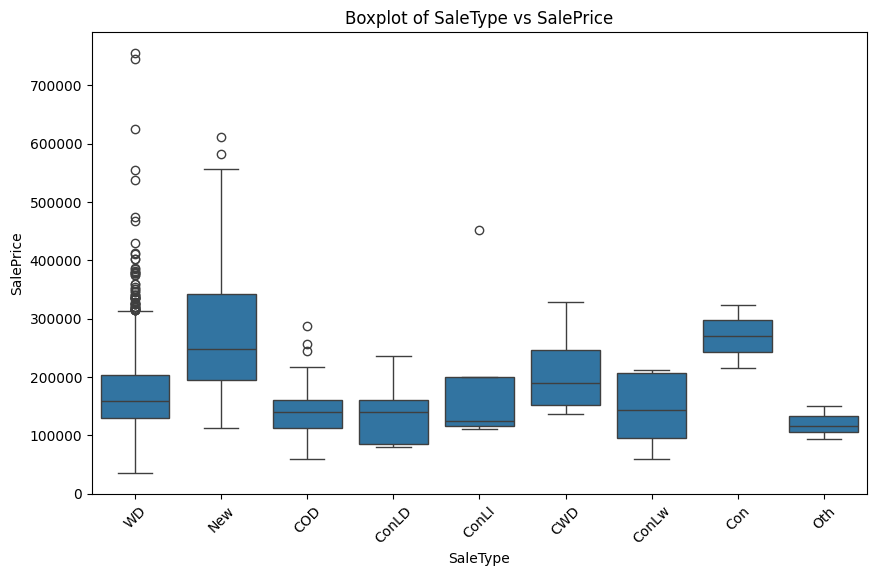

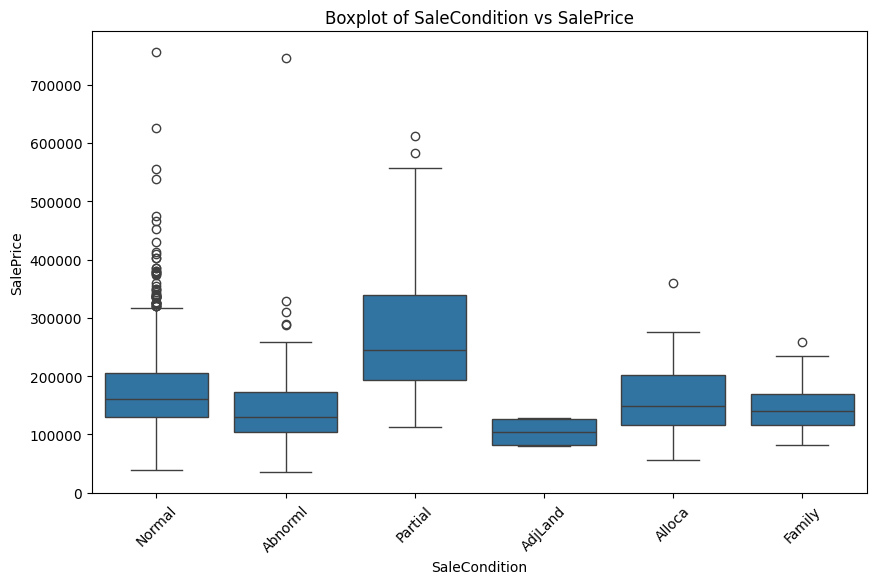

In [66]:
import seaborn as sns

for col in categoricals.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=categoricals[col], y=y)  
    plt.title(f'Boxplot of {col} vs SalePrice')
    plt.xlabel(col)
    plt.ylabel("SalePrice")
    plt.xticks(rotation=45) 
    plt.show()



In [67]:
# Keep only the categorical predictors that seem to have differing SalePrice distributions
columns_to_drop = ['LandContour', 'LotConfig', 'LandSlope', 'MasVnrType', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageCond', 'Fence', 'MiscFeature']
categoricals = categoricals.drop(columns=columns_to_drop)

# Make dummy variables
dummies = pd.get_dummies(categoricals)
dummies = dummies.astype('float')
# Create a full working dataframe
housing_data = pd.concat([housing_data, dummies], axis=1)


Now that we have all relevant data, we can make a multiple linear regression model using least squares estimation. 

In [68]:
# Form the design matrix, which starts with a column of 1's
corm = housing_data.corr()
X = housing_data.copy()
X.insert(0, 'Intercept', 1)

cm2 = X.corr()

# Convert X and y to NumPy arrays for operations
X = X.values
y = y.values

step1 = (X.T @ X)
step2 = np.linalg.inv(step1)
step3 = step2 @ X.T
step4 = step3 @ y
# Find betas using beta = (X'X)^-1 X'y
beta = step4

print(beta)


[ 9.30849204e+20  1.83917835e+04 -1.78085133e+02  1.09442309e+07
  3.41408390e+07  3.89115350e+05 -1.60090784e+06 -5.66573002e+03
  2.97832887e+16  2.97832887e+16  2.97832887e+16 -2.97832887e+16
  7.92971023e+02 -1.43268147e+04 -2.28360403e+04  8.42787582e+06
  9.27262960e+06  9.54639918e+06 -5.09506132e+03 -4.12472058e+03
 -1.65631562e+03 -1.43702930e+04  1.05309020e+04 -1.83314675e+03
 -5.41134685e+19 -5.41134685e+19 -5.41134685e+19 -5.41134685e+19
 -5.41134685e+19 -1.73407028e+20 -1.73407028e+20 -1.73407028e+20
  4.35212590e+19  4.35212590e+19  4.35212590e+19  4.35212590e+19
  5.44964341e+19  5.44964341e+19  5.44964341e+19  5.44964341e+19
  5.44964341e+19  5.44964341e+19  5.44964341e+19  5.44964341e+19
  5.44964341e+19  5.44964341e+19  5.44964341e+19  5.44964341e+19
  5.44964341e+19  5.44964341e+19  5.44964341e+19  5.44964341e+19
  5.44964341e+19  5.44964341e+19  5.44964341e+19  5.44964341e+19
  5.44964341e+19  5.44964341e+19  5.44964341e+19  5.44964341e+19
  5.44964341e+19 -4.34712

Now I will perform the global F test to examine the overall significance of the model. 

In [70]:
n = X.shape[0]  

# Number of predictors (excluding intercept)
p = X.shape[1] - 1  

# Predicted values
y_hat = X @ beta  

# Compute Sum of Squares for Regression (SSR)
y_mean = np.mean(y)
SSR = np.sum((y_hat - y_mean) ** 2)

# Compute Sum of Squared Errors (SSE)
SSE = np.sum((y - y_hat) ** 2)

# Compute Mean Squares
MSR = SSR / p  # Mean Square Regression
MSE = SSE / (n - p - 1)  # Mean Square Error

# Compute F-statistic
F = MSR / MSE

print(f"F-statistic: {F}")

import scipy.stats as stats
df1 = p  # Number of predictors
df2 = n - p - 1  # Degrees of freedom for error

# Compute p-value
p_value = 1 - stats.f.cdf(F, df1, df2)
print(f"p-value: {p_value}")


F-statistic: 6.9740041187876125
p-value: 1.1102230246251565e-16


Given the extremely small p-value for this test, it is safe to say that this model is significant and overall, it does model a linear relationship with SalePrice. Coming soon: perform individual t-tests, find $R^2$ and $R^2_a$, attempt to find a smaller model